In [150]:
import pandas as pd
import matplotlib.pylab as plt 
import numpy as np
import requests
from config import geoapify_key
import json
from scipy.stats import linregress
import hvplot.pandas
import scipy.stats as stats

In [151]:
# importing table which contain used cars lot in Canada
data_df = pd.read_csv("Dataset/ca-dealers-used.csv")

# performing some cleaning on the states as OH and SC are not in Canada
data_df['state'] = data_df['state'].replace({"OH" : "ON", "SC" :"QC",})

# removing the state WA as it is part of UNITED STATES OF AMERICA
data_df = data_df[data_df['state']!= "WA"]
data_df

/var/folders/qh/th17k7b126bdp6fpt44nzdb80000gn/T/ipykernel_40385/2592526909.py:2: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv("Dataset/ca-dealers-used.csv")


,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2
4,ac40c9fc-0676,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,acura pickering,575 Kingston Road,Pickering,ON,L1V 3N7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393598,f71c5738-33d8,WDC0G5EB8KF614677,47995.0,22108.0,M0684,2019.0,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,4WD,Automatic,Electric / Unleaded,2.0,I,mercedes-benz granby,1225 Rue Principale,Granby,QC,J2J 0M3
393599,873d76f0-18d2,WDC0G5EB9JF465808,42995.0,55316.0,D13339,2018.0,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,4WD,Automatic,Electric / Unleaded,2.0,I,groupe park avenue - regroupement automobile,8840 Boulevard Taschereau,Brossard,QC,J4X 1C2
393600,7ead9dba-6cdd,WDC0G5EB9JF465808,42995.0,55316.0,D13339,2018.0,Mercedes-Benz,GLC-Class,GLC350e,SUV,...,4WD,Automatic,Electric / Unleaded,2.0,I,le mga centre park avenue la prairie,150-b Boulevard Taschereau,La Prairie,QC,J5R 1S8
393601,efa897c2-a52f,WP1BE2AY4LDA55072,115995.0,NaN,NaN,2020.0,Porsche,Cayenne Coupe,E-Hybrid,SUV,...,4WD,Automatic,Electric / Unleaded,3.0,V,porsche centre winnipeg,660 Pembina Highway,Winnipeg,MB,R3M 2M5


In [152]:
# selecting columsn that are important for our analysis
clean_df = data_df[["make","model","year","fuel_type","miles","price","engine_size","body_type","city","state"]]
clean_df

,make,model,year,fuel_type,miles,price,engine_size,body_type,city,state
0,Acura,NSX,2017.0,Electric / Premium Unleaded,9966.0,179999.0,3.5,Coupe,Edmundston,NB
1,Acura,NSX,2017.0,Electric / Premium Unleaded,5988.0,179995.0,3.5,Coupe,Notre-dame-des-pins,QC
2,Acura,NSX,2017.0,Electric / Premium Unleaded,24242.0,168528.0,3.5,Coupe,Coquitlam,BC
3,Acura,NSX,2020.0,Electric / Premium Unleaded,6637.0,220000.0,3.5,Coupe,Pickering,ON
4,Acura,NSX,2020.0,Electric / Premium Unleaded,6637.0,220000.0,3.5,Coupe,Pickering,ON
...,...,...,...,...,...,...,...,...,...,...
393598,Mercedes-Benz,GLC-Class,2019.0,Electric / Unleaded,22108.0,47995.0,2.0,SUV,Granby,QC
393599,Mercedes-Benz,GLC-Class,2018.0,Electric / Unleaded,55316.0,42995.0,2.0,SUV,Brossard,QC
393600,Mercedes-Benz,GLC-Class,2018.0,Electric / Unleaded,55316.0,42995.0,2.0,SUV,La Prairie,QC
393601,Porsche,Cayenne Coupe,2020.0,Electric / Unleaded,NaN,115995.0,3.0,SUV,Winnipeg,MB


In [153]:
# importing second table to view the fuel consumption per car model
data_2_df = pd.read_csv("Dataset/Fuel_Consumption_2000-2022.csv")
data_2_df


,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,2022,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,2022,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,2022,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,2022,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [154]:
# selecting appropriate columns in the second table and renaming them to merge with first table
data_2_df = data_2_df[["YEAR", "MAKE", "MODEL","FUEL","FUEL CONSUMPTION", "HWY (L/100 km)","COMB (L/100 km)", "COMB (mpg)", "EMISSIONS"]]
data_2_df = data_2_df.rename(columns={"MODEL":"model","MAKE":"make","YEAR":"year","FUEL": "fuel_type"})
data_2_df['fuel_type'] = data_2_df['fuel_type'].replace({'X': 'Unleaded','Z' : 'Premium Unleaded', 'E' : 'Electric','D' : 'Diesel'})


In [155]:
# perform merging of 2 datasets
merge_df = pd.merge(clean_df,data_2_df,how = "outer",on = ["make","model","year","fuel_type"])
merge_df

,make,model,year,fuel_type,miles,price,engine_size,body_type,city,state,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,Acura,NSX,2017.0,Electric / Premium Unleaded,9966.0,179999.0,3.5,Coupe,Edmundston,NB,NaN,NaN,NaN,NaN,NaN
1,Acura,NSX,2017.0,Electric / Premium Unleaded,5988.0,179995.0,3.5,Coupe,Notre-dame-des-pins,QC,NaN,NaN,NaN,NaN,NaN
2,Acura,NSX,2017.0,Electric / Premium Unleaded,24242.0,168528.0,3.5,Coupe,Coquitlam,BC,NaN,NaN,NaN,NaN,NaN
3,Acura,NSX,2017.0,Electric / Premium Unleaded,18281.0,155771.0,3.5,Coupe,Montral,QC,NaN,NaN,NaN,NaN,NaN
4,Acura,NSX,2017.0,Electric / Premium Unleaded,18281.0,155771.0,3.5,Coupe,Montral,QC,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464897,Volvo,XC40 T5 AWD,2022.0,Premium Unleaded,NaN,NaN,NaN,NaN,NaN,NaN,10.7,7.7,9.4,30.0,219.0
464898,Volvo,XC60 B5 AWD,2022.0,Premium Unleaded,NaN,NaN,NaN,NaN,NaN,NaN,10.5,8.1,9.4,30.0,219.0
464899,Volvo,XC60 B6 AWD,2022.0,Premium Unleaded,NaN,NaN,NaN,NaN,NaN,NaN,11.0,8.7,9.9,29.0,232.0
464900,Volvo,XC90 T5 AWD,2022.0,Premium Unleaded,NaN,NaN,NaN,NaN,NaN,NaN,11.5,8.4,10.1,28.0,236.0


In [156]:
#importing 3 table as a csv - this will allow associate cars with the respective countries
manufacturer_df = pd.read_csv("Dataset/manufacturers.csv")
manufacturer_df["make"] = manufacturer_df["make"].str.title()

# merge the 3rd table with the earlier merged file.
final_df = pd.merge(merge_df,manufacturer_df[["make","country"]],on = "make")
final_df = final_df.dropna()
final_df.head()


,make,model,year,fuel_type,miles,price,engine_size,body_type,city,state,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,country
1793,Acura,ILX,2018.0,Premium Unleaded,39000.0,19999.0,2.4,Sedan,London,ON,9.4,6.8,8.2,34.0,192.0,Japan
1794,Acura,ILX,2018.0,Premium Unleaded,25661.0,23240.0,2.4,Sedan,Halifax,NS,9.4,6.8,8.2,34.0,192.0,Japan
1795,Acura,ILX,2018.0,Premium Unleaded,21675.0,20999.0,2.4,Sedan,Chatham-kent,ON,9.4,6.8,8.2,34.0,192.0,Japan
1796,Acura,ILX,2018.0,Premium Unleaded,21675.0,21999.0,2.4,Sedan,Leamington,ON,9.4,6.8,8.2,34.0,192.0,Japan
1797,Acura,ILX,2018.0,Premium Unleaded,32144.0,22776.0,2.4,Sedan,Montral,QC,9.4,6.8,8.2,34.0,192.0,Japan


In [157]:
#considering only cars between 2017 and 2022
final_tweak_df = final_df.loc[(final_df["year"] >= 2017) & (final_df["year"] <= 2022),:]
final_tweak_df.rename(columns={'make': 'BRAND', 'model':'MODEL', 'year':'YEAR','fuel_type':'FUEL TYPE',
                       'state':'STATE', 'miles':'MILES','price': 'PRICE', 'engine_size':'ENGINE SIZE',	
                       'body_type':'BODY TYPE', 'city':'CITY','country':'COUNTRY'}, inplace=True)
final_tweak_df

,BRAND,MODEL,YEAR,FUEL TYPE,MILES,PRICE,ENGINE SIZE,BODY TYPE,CITY,STATE,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,COUNTRY
1793,Acura,ILX,2018.0,Premium Unleaded,39000.0,19999.0,2.4,Sedan,London,ON,9.4,6.8,8.2,34.0,192.0,Japan
1794,Acura,ILX,2018.0,Premium Unleaded,25661.0,23240.0,2.4,Sedan,Halifax,NS,9.4,6.8,8.2,34.0,192.0,Japan
1795,Acura,ILX,2018.0,Premium Unleaded,21675.0,20999.0,2.4,Sedan,Chatham-kent,ON,9.4,6.8,8.2,34.0,192.0,Japan
1796,Acura,ILX,2018.0,Premium Unleaded,21675.0,21999.0,2.4,Sedan,Leamington,ON,9.4,6.8,8.2,34.0,192.0,Japan
1797,Acura,ILX,2018.0,Premium Unleaded,32144.0,22776.0,2.4,Sedan,Montral,QC,9.4,6.8,8.2,34.0,192.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434802,Alfa Romeo,Stelvio,2020.0,Premium Unleaded,5095.0,53888.0,2.0,SUV,Toronto,ON,10.3,8.1,9.3,30.0,218.0,Italy
434804,Alfa Romeo,Stelvio,2021.0,Premium Unleaded,90.0,67719.0,2.0,SUV,Edmonton,AB,10.3,8.1,9.3,30.0,218.0,Italy
434805,Alfa Romeo,Stelvio,2021.0,Premium Unleaded,90.0,67719.0,2.0,SUV,Calgary,AB,10.3,8.1,9.3,30.0,218.0,Italy
434806,Alfa Romeo,Stelvio,2021.0,Premium Unleaded,90.0,80859.0,2.0,SUV,Edmonton,AB,10.3,8.1,9.3,30.0,218.0,Italy


In [158]:
# price comparison of cars in different provinces
average_price = final_tweak_df.groupby(['MODEL', 'STATE','YEAR','MILES'])['PRICE'].mean()
average_price

MODEL  STATE  YEAR    MILES  
300    AB     2018.0  37361.0    31887.0
                      38181.0    26988.0
                      39956.0    28987.0
                      70282.0    23980.0
                      73231.0    27990.0
                                  ...   
Yaris  QC     2018.0  97425.0    13495.0
              2020.0  680.0      19995.0
                      1243.0     17994.0
                      2800.0     21902.0
                      5109.0     17995.0
Name: PRICE, Length: 36093, dtype: float64

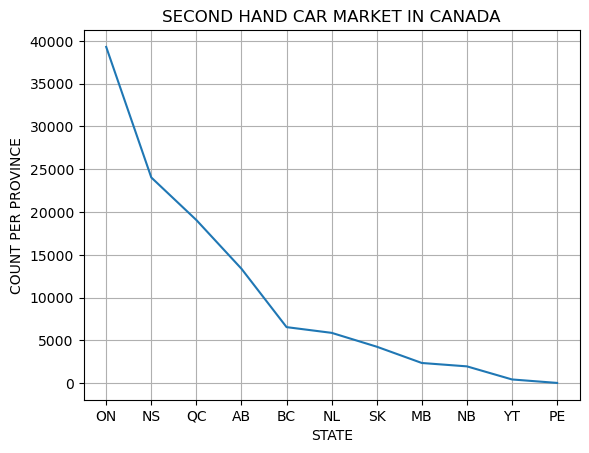

In [159]:
# second car market in canada
state_all_list = final_tweak_df['STATE'].unique()
state_cars_count = final_tweak_df['STATE'].value_counts()
final_tweak_df['STATE'].value_counts().plot.line()
plt.xticks(range(len(state_all_list)), state_all_list)


# Add labels and a title
plt.xlabel('STATE')
plt.ylabel('COUNT PER PROVINCE')
plt.title('SECOND HAND CAR MARKET IN CANADA')
plt.grid()

In [160]:
# Number of cars in the second hand market with zero mileage.
new_second_cars = final_tweak_df.loc[final_tweak_df['MILES']==0,:].reset_index()
new_second_grp = new_second_cars.groupby('BRAND').value_counts()
new_second_count = new_second_cars.groupby('BRAND').count()
new_second_grp.head(124)

BRAND  index   MODEL   YEAR    FUEL TYPE         MILES  PRICE    ENGINE SIZE  BODY TYPE  CITY       STATE  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  COMB (mpg)  EMISSIONS  COUNTRY
Audi   271547  Q5      2018.0  Premium Unleaded  0.0    31998.0  2.0          SUV        Thornhill  ON     10.4              8.6             9.6              29.0        226.0      Germany    1
       271550  Q5      2018.0  Premium Unleaded  0.0    31998.0  2.0          SUV        Caledon    ON     10.4              8.6             9.6              29.0        226.0      Germany    1
       271551  Q5      2018.0  Premium Unleaded  0.0    31998.0  2.0          SUV        Vaughan    ON     10.4              8.6             9.6              29.0        226.0      Germany    1
       274918  RS 3    2018.0  Premium Unleaded  0.0    54995.0  2.5          Sedan      Brossard   QC     12.4              8.3             10.5             27.0        248.0      Germany    1
       274919  RS 3    2018.0  Prem

In [161]:
def pie_chart(datas,case,angle):
    """
    This is a function to generate pie_chart taking the dataframe and respective field as paramter,
    case refers to which case you want to plot, in this analysis there are 2 inputs:
    1. "carcount" - Count the number of second hand cars that have 0 mileage in the country.
    2. "bodytype" - count the number of second hand cars as per body type.
    and the startangle parameter integer format
    """
    list1 = datas.unique().tolist()
    count1 = datas.value_counts()
    if case =="carcount":
        explode = [0.1,0.1,0.1,0.1,0.1,0.4,0.1,1,0.4]
        label_legend = ["AB: Alberta", "NS : Nova Scotia","SK : Saskatchewan","ON : Ontario","NB : New Brunswick","BC :British Columbia","NF : Newfoundland and Labrador","QC : Quebec", "MN :Manitoba"]
    
    elif case =="bodytype":
        explode = [0.1,0.1,0.1,0.1,0.4]
        label_legend =""

    # plotting the pie chart
    plt.pie(count1,explode = explode, labels =list1,autopct= '%2.1f%%',shadow = False , startangle= 105)
    # to set the label beside the pie chart    
    plt.legend(label_legend,bbox_to_anchor=(1.1, 1))
    return


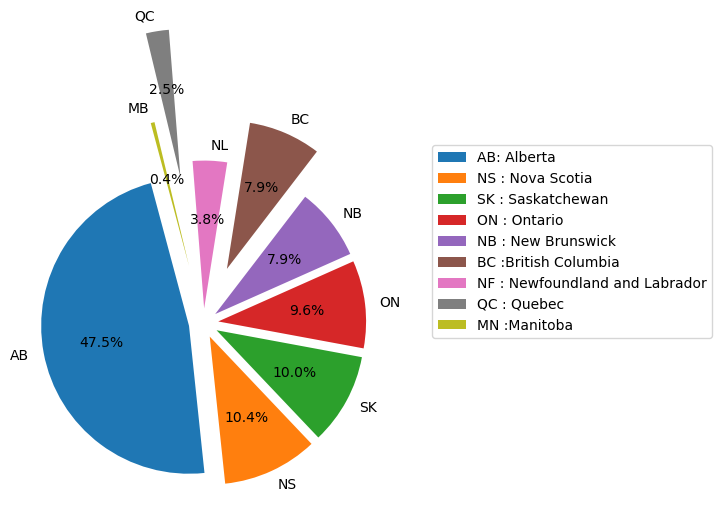

In [162]:
#forming count of new second hand cars in respective province
carcount = "carcount"
pie_chart(new_second_cars['STATE'],carcount,90)

Text(0.5, 1.0, ' Cars as per body type in Canada')

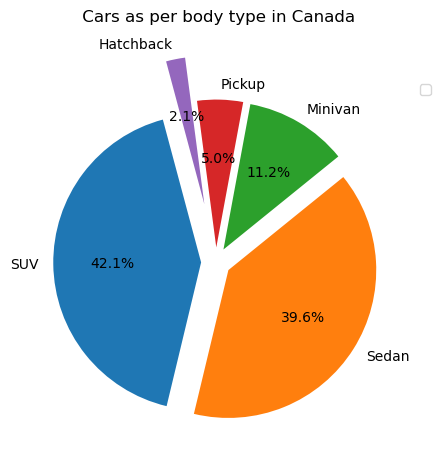

In [163]:
bodytype = "bodytype"
pie_chart(new_second_cars['BODY TYPE'],bodytype,45)
plt.title(" Cars as per body type in Canada",loc = "Center", pad= 40)

In [164]:
country_grp_cars = final_tweak_df.groupby("COUNTRY")
country_cars = country_grp_cars['COUNTRY'].count()
print(country_cars)

country_values = final_tweak_df['BODY TYPE'].unique()
print(country_values)

COUNTRY
Germany        11835
Italy            109
Japan          34979
South Korea    27284
UK               378
USA            42629
Name: COUNTRY, dtype: int64
['Sedan' 'Coupe' 'SUV' 'Minivan' 'Pickup' 'Convertible' 'Hatchback'
 'Crossover' 'Cargo Van' 'Targa' 'Wagon']


In [165]:
# Number of unqiue Brands in the final dataset 
brand_cars = final_tweak_df['BRAND'].unique().tolist()
print(brand_cars)

['Acura', 'Dodge', 'Chrysler', 'Ford', 'Chevrolet', 'Buick', 'Cadillac', 'Nissan', 'Volkswagen', 'Mercedes-Benz', 'Toyota', 'Lincoln', 'Land Rover', 'Bentley', 'Audi', 'Porsche', 'Maserati', 'Honda', 'Jeep', 'Mazda', 'Hyundai', 'Kia', 'Mitsubishi', 'Subaru', 'Rolls-Royce', 'Aston Martin', 'Lamborghini', 'Alfa Romeo']


In [166]:
def countries_analysis(dataframe,country):
    """
    Function to perform analysis and plot graphs for respective country analysis by taking the 
    country values from the final table and country
    1. to create table of respective country with mean of emissions, Mileage in City, Mileage in HWY and COMB
    """
    country_cars_mpg = dataframe[dataframe["COUNTRY"]== country]
    emissions = country_cars_mpg.groupby('BRAND')['EMISSIONS'].mean()
    hwy = country_cars_mpg.groupby('BRAND')['HWY (L/100 km)'].mean()
    comb =  country_cars_mpg.groupby('BRAND')['COMB (L/100 km)'].mean()
    mpg = country_cars_mpg.groupby('BRAND')['COMB (mpg)'].mean()
    city_mil = country_cars_mpg.groupby('BRAND')['FUEL CONSUMPTION'].mean()
    summary = ({"COUNTRY" : emissions.index.values,
              "EMISSIONS" : (round(emissions,2)),
              "MILEAGE CITY(L/100 KM)" : round(city_mil),
              "MILEAGE HWY(L/100 KM)" : round(hwy),
              "COMB (L/100 KM)" : round(comb),
              "COMB (MPG)": round(mpg)})
    summary_df = pd.DataFrame(summary)
    summary_df.reset_index(inplace= True, drop = True)
    print(summary_df)
    summary_df['EMISSIONS'] = (summary_df['EMISSIONS']/(summary_df["COMB (MPG)"]*1.609/3.78))
    summary_df.reset_index()
    summary_short_df = summary_df[['COUNTRY','EMISSIONS', 'MILEAGE CITY(L/100 KM)','MILEAGE HWY(L/100 KM)','COMB (L/100 KM)']]
    multi_plot = summary_short_df.plot(kind="bar", figsize=(20,8))
    # PandasPlot.set_xticklabels() can be used to set the tick labels as well
    multi_plot.set_xticklabels(summary_short_df["COUNTRY"])
    multi_plot.set_ylabel("L/100 KM")
    multi_plot.set_title(f"{country} Cars  showing emisssions along with Mileage in City, Highway and COMB",fontsize = 20)
    legend = multi_plot.legend()
    legend.get_texts()[0].set_text('Emission in L/km')
    plt.show()
    plt.tight_layout()
    


      COUNTRY  EMISSIONS  MILEAGE CITY(L/100 KM)  MILEAGE HWY(L/100 KM)  \
0       Acura     200.66                    10.0                    7.0   
1       Honda     185.58                     9.0                    7.0   
2       Mazda     196.81                     9.0                    7.0   
3  Mitsubishi     161.81                     7.0                    6.0   
4      Nissan     199.58                    10.0                    7.0   
5      Subaru     215.07                    10.0                    8.0   
6      Toyota     194.78                     9.0                    7.0   

   COMB (L/100 KM)  COMB (MPG)  
0              9.0        33.0  
1              8.0        36.0  
2              8.0        34.0  
3              7.0        41.0  
4              9.0        34.0  
5              9.0        31.0  
6              8.0        35.0  


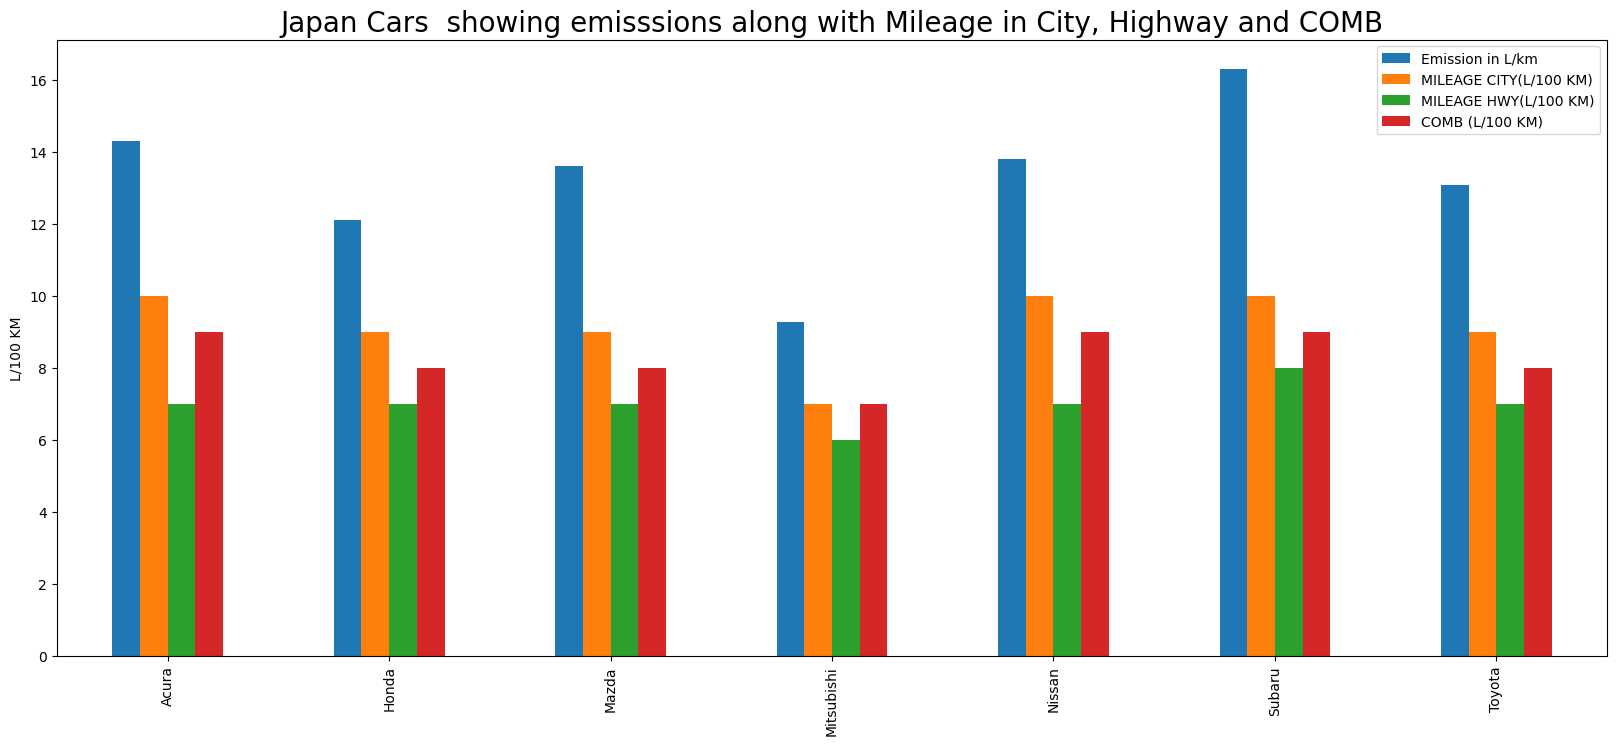

     COUNTRY  EMISSIONS  MILEAGE CITY(L/100 KM)  MILEAGE HWY(L/100 KM)  \
0      Buick     215.28                    10.0                    8.0   
1   Cadillac     237.81                    11.0                    9.0   
2  Chevrolet     197.38                     9.0                    7.0   
3   Chrysler     263.23                    13.0                    9.0   
4      Dodge     267.97                    14.0                    9.0   
5       Ford     233.49                    11.0                    8.0   
6       Jeep     221.85                    11.0                    8.0   
7    Lincoln     254.50                    12.0                    9.0   

   COMB (L/100 KM)  COMB (MPG)  
0              9.0        31.0  
1             10.0        28.0  
2              8.0        35.0  
3             11.0        25.0  
4             11.0        25.0  
5             10.0        29.0  
6              9.0        30.0  
7             11.0        26.0  


<Figure size 640x480 with 0 Axes>

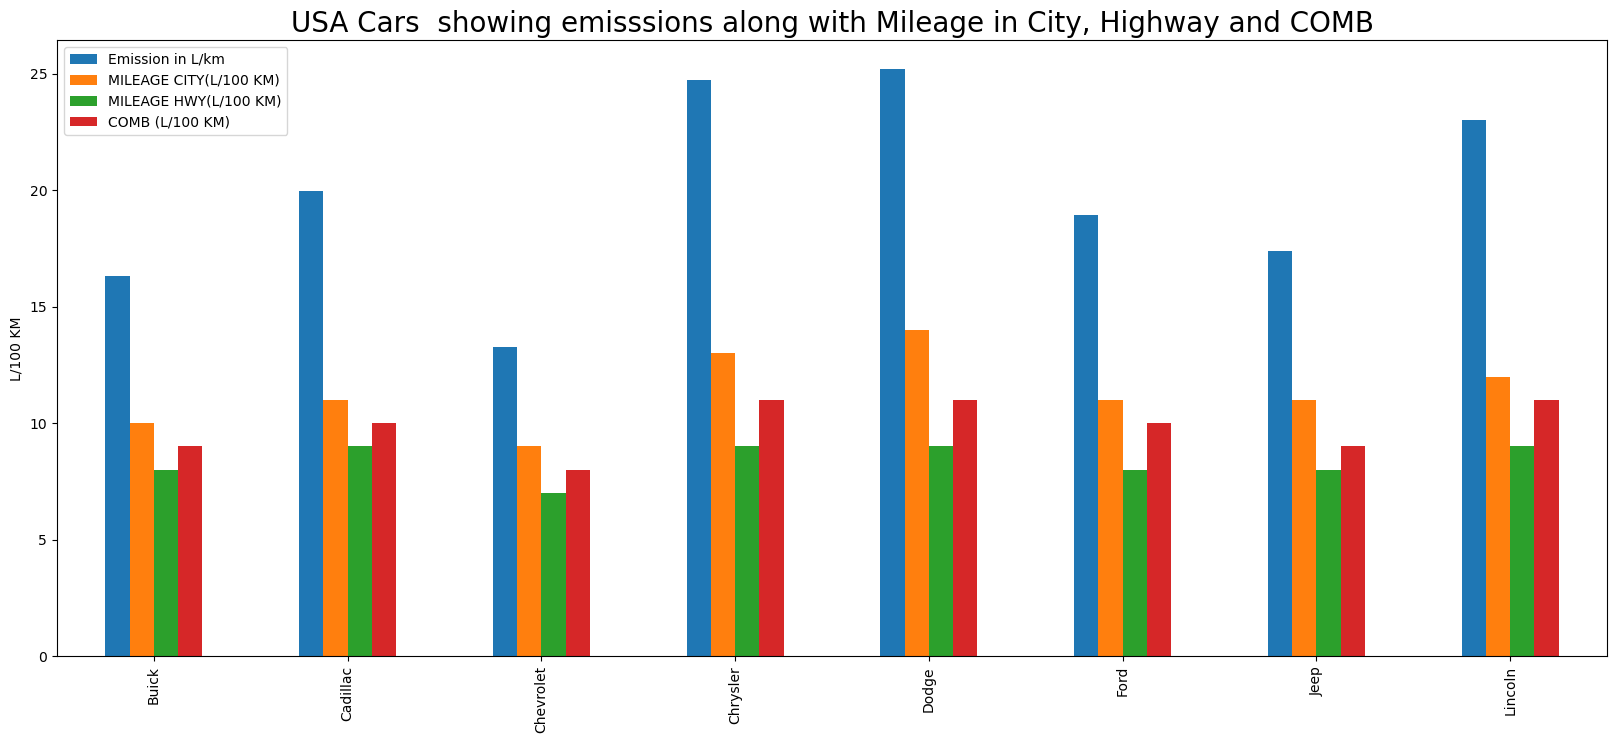

         COUNTRY  EMISSIONS  MILEAGE CITY(L/100 KM)  MILEAGE HWY(L/100 KM)  \
0           Audi     239.85                    11.0                    9.0   
1  Mercedes-Benz     298.89                    14.0                   11.0   
2        Porsche     255.74                    12.0                   10.0   
3     Volkswagen     187.91                     9.0                    7.0   

   COMB (L/100 KM)  COMB (MPG)  
0             10.0        28.0  
1             13.0        22.0  
2             11.0        26.0  
3              8.0        36.0  


<Figure size 640x480 with 0 Axes>

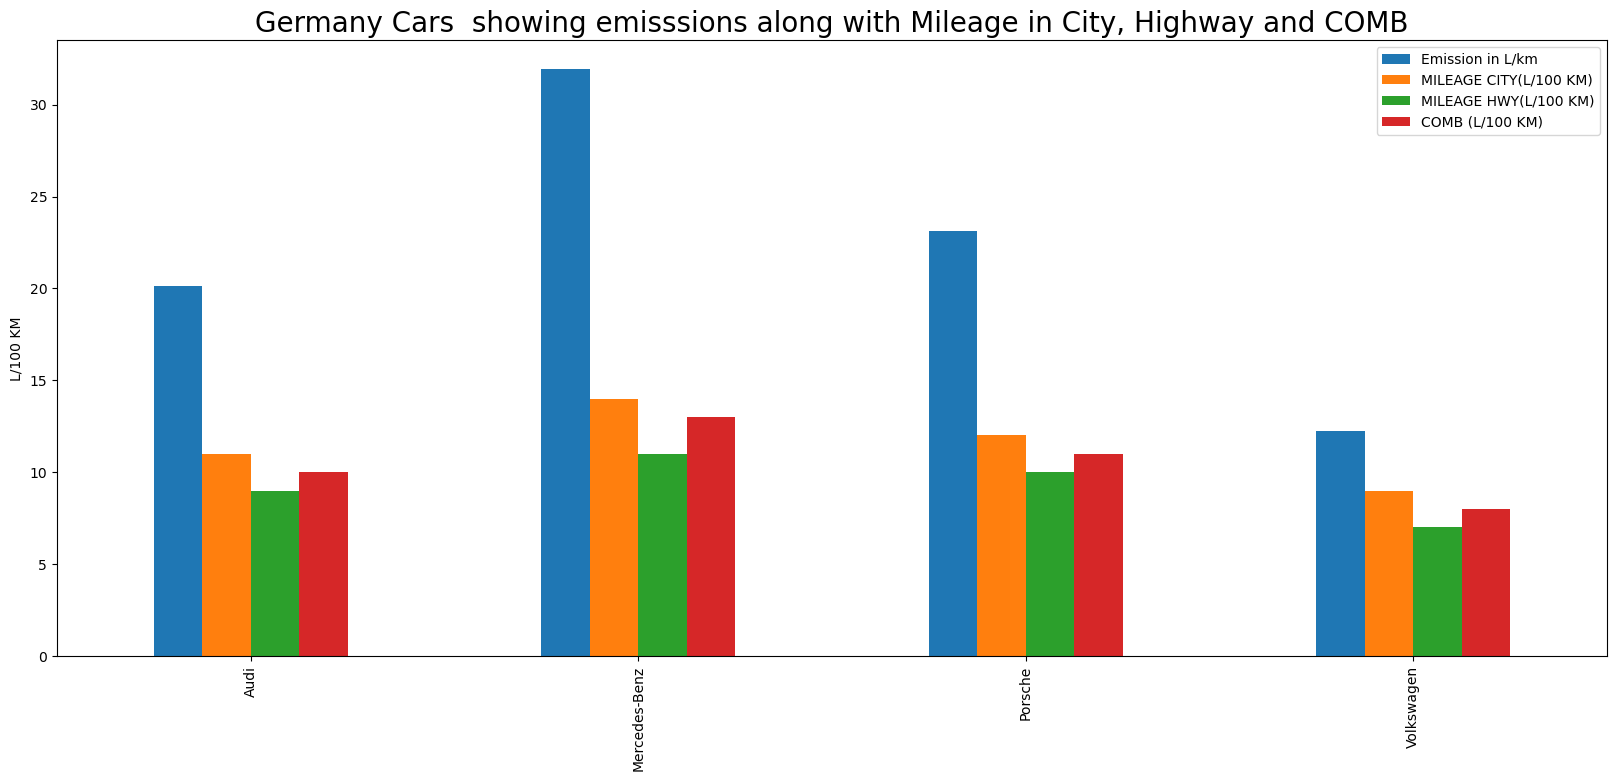

        COUNTRY  EMISSIONS  MILEAGE CITY(L/100 KM)  MILEAGE HWY(L/100 KM)  \
0  Aston Martin     346.00                    18.0                   11.0   
1       Bentley     344.08                    18.0                   11.0   
2    Land Rover     260.61                    12.0                   10.0   
3   Rolls-Royce     391.31                    20.0                   13.0   

   COMB (L/100 KM)  COMB (MPG)  
0             15.0        19.0  
1             15.0        19.0  
2             11.0        26.0  
3             17.0        17.0  


<Figure size 640x480 with 0 Axes>

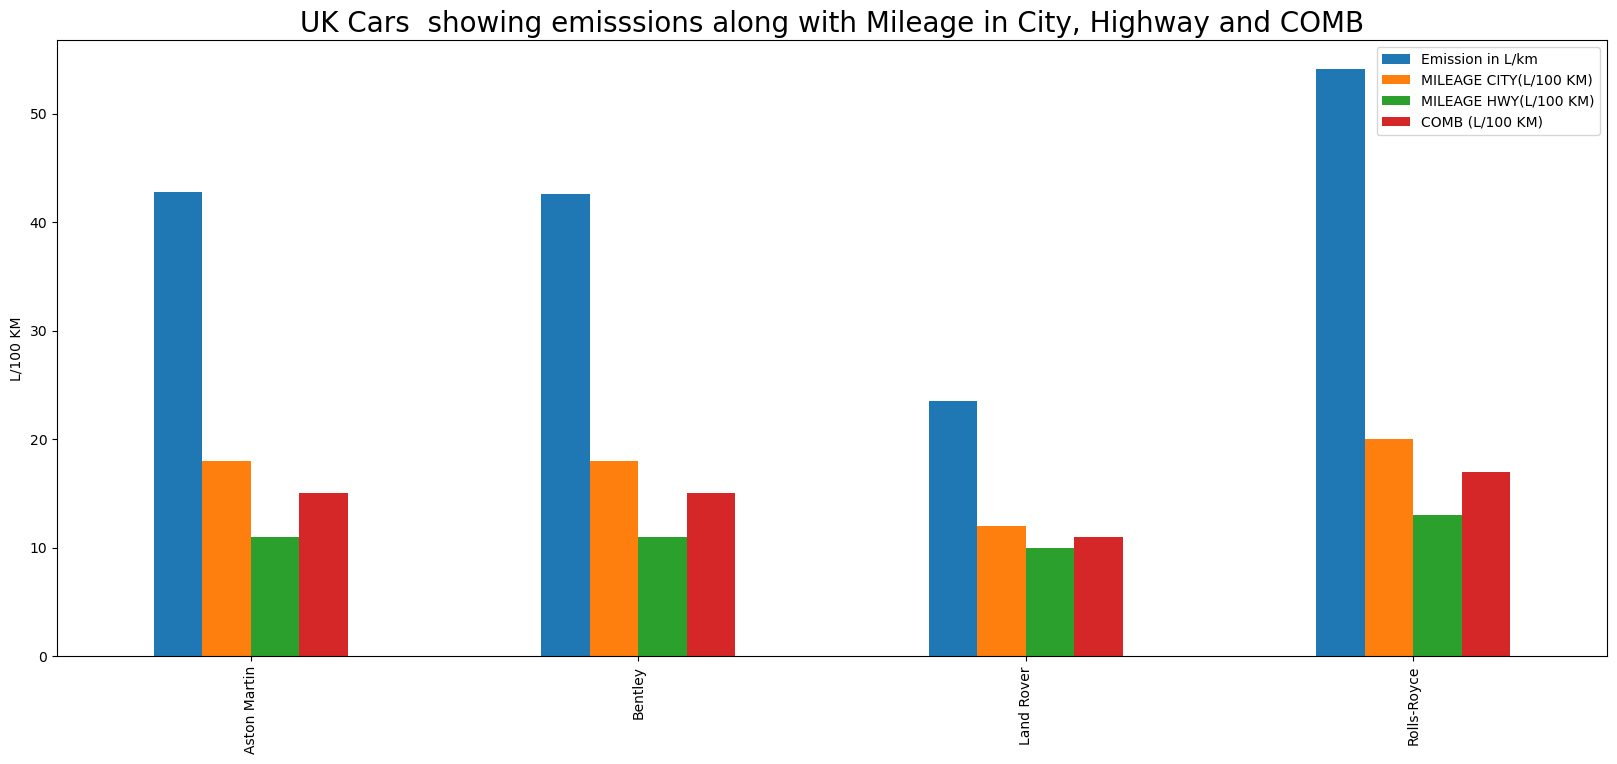

       COUNTRY  EMISSIONS  MILEAGE CITY(L/100 KM)  MILEAGE HWY(L/100 KM)  \
0   Alfa Romeo     211.50                    10.0                    8.0   
1  Lamborghini     372.00                    19.0                   13.0   
2     Maserati     312.54                    15.0                   11.0   

   COMB (L/100 KM)  COMB (MPG)  
0              9.0        31.0  
1             16.0        18.0  
2             13.0        21.0  


<Figure size 640x480 with 0 Axes>

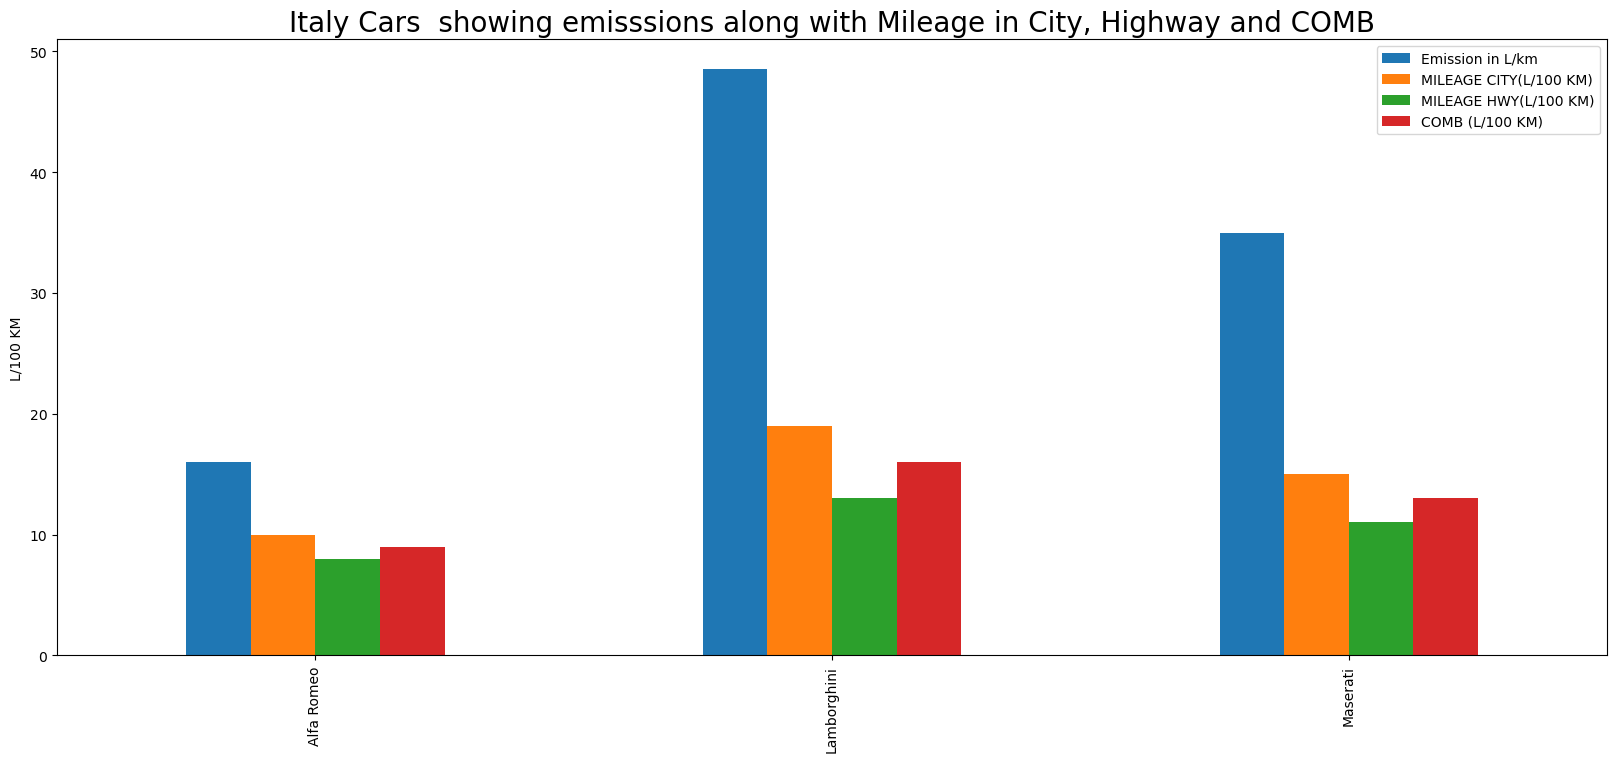

   COUNTRY  EMISSIONS  MILEAGE CITY(L/100 KM)  MILEAGE HWY(L/100 KM)  \
0  Hyundai     198.08                     9.0                    7.0   
1      Kia     207.11                    10.0                    8.0   

   COMB (L/100 KM)  COMB (MPG)  
0              8.0        34.0  
1              9.0        32.0  


<Figure size 640x480 with 0 Axes>

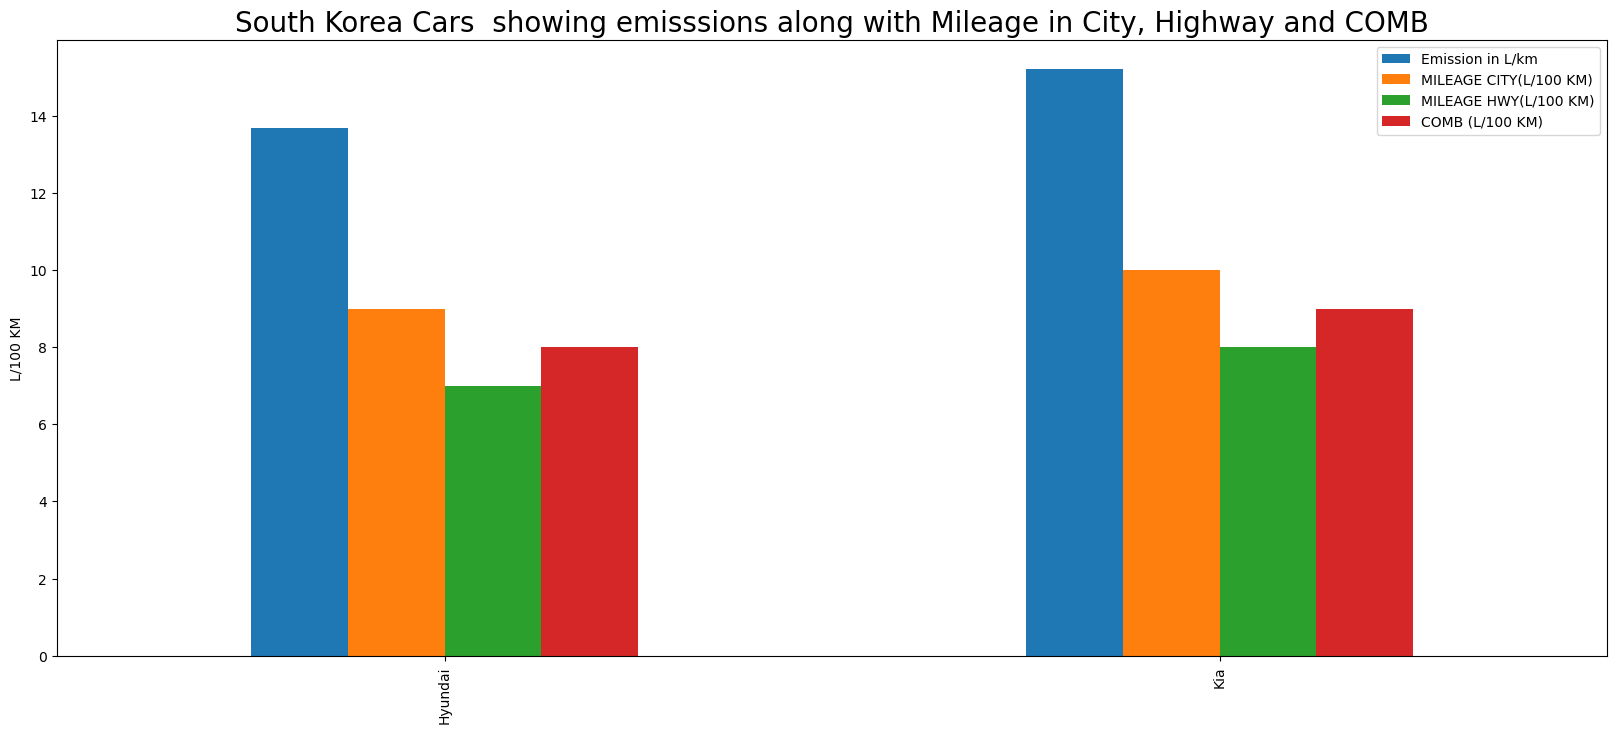

<Figure size 640x480 with 0 Axes>

In [167]:
countries = final_tweak_df["COUNTRY"].unique()
for counts in countries:
    summ = countries_analysis(final_tweak_df,counts)


In [168]:
final_tweak_df['BODY TYPE'].unique()

array(['Sedan', 'Coupe', 'SUV', 'Minivan', 'Pickup', 'Convertible',
       'Hatchback', 'Crossover', 'Cargo Van', 'Targa', 'Wagon'],
      dtype=object)

In [169]:
#most fuel efficient car
fuel_eff = final_tweak_df.loc[final_tweak_df['EMISSIONS'] <= 152.0,:]
fuel_eff = fuel_eff.groupby('MODEL').head()
fuel_eff

,BRAND,MODEL,YEAR,FUEL TYPE,MILES,PRICE,ENGINE SIZE,BODY TYPE,CITY,STATE,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,COUNTRY
304005,Honda,Fit,2018.0,Unleaded,62046.0,17313.0,1.5,Hatchback,Windsor,ON,7.0,5.9,6.5,43.0,151.0,Japan
304008,Honda,Fit,2018.0,Unleaded,58135.0,15987.0,1.5,Hatchback,Qubec,QC,7.0,5.9,6.5,43.0,151.0,Japan
304011,Honda,Fit,2018.0,Unleaded,38200.0,16595.0,1.5,Hatchback,Saint-apollinaire,QC,7.0,5.9,6.5,43.0,151.0,Japan
304014,Honda,Fit,2018.0,Unleaded,53430.0,15595.0,1.5,Hatchback,Victoriaville,QC,7.0,5.9,6.5,43.0,151.0,Japan
304017,Honda,Fit,2018.0,Unleaded,24689.0,17900.0,1.5,Hatchback,Markham,ON,7.0,5.9,6.5,43.0,151.0,Japan
422185,Mitsubishi,Mirage,2019.0,Unleaded,47400.0,11199.0,1.2,Hatchback,Welland,ON,6.6,5.6,6.2,46.0,143.0,Japan
422186,Mitsubishi,Mirage,2019.0,Unleaded,47400.0,11199.0,1.2,Hatchback,Welland,ON,7.1,5.8,6.5,43.0,151.0,Japan
422187,Mitsubishi,Mirage,2019.0,Unleaded,50400.0,11199.0,1.2,Hatchback,Welland,ON,6.6,5.6,6.2,46.0,143.0,Japan
422188,Mitsubishi,Mirage,2019.0,Unleaded,50400.0,11199.0,1.2,Hatchback,Welland,ON,7.1,5.8,6.5,43.0,151.0,Japan
422189,Mitsubishi,Mirage,2019.0,Unleaded,49565.0,15888.0,1.2,Hatchback,Medicine Hat,AB,6.6,5.6,6.2,46.0,143.0,Japan


In [170]:
pickups_df = final_tweak_df[final_tweak_df['BODY TYPE'] == "Sedan"]
pickups_grp = pickups_df.groupby('MODEL')
pickups_engine_size = pickups_grp['ENGINE SIZE'].unique()
pickups_engine_size

MODEL
300                      [3.6, 5.7]
A4                            [2.0]
A8                            [4.0]
ATS                           [2.0]
Accent                        [1.6]
Accord                   [1.5, 2.0]
Altima                        [2.5]
Avalon                        [3.5]
CT4                           [2.0]
CT5                           [3.0]
CT6                           [3.0]
Camry                    [2.5, 3.5]
Charger                  [3.6, 5.7]
Corolla                       [1.8]
Cruze                         [1.4]
Elantra                  [2.0, 1.6]
Fiesta                        [1.6]
Flying Spur              [6.0, 4.0]
Focus                    [1.0, 2.0]
Forte                         [2.0]
Fusion         [2.0, 2.5, 1.5, 2.7]
Ghibli                        [3.0]
Ghost                         [6.6]
Giulia                   [2.9, 2.0]
ILX                           [2.4]
Impala                        [2.5]
Jetta                    [2.0, 1.4]
K5                    

In [171]:
emission_efficient_cars = final_tweak_df.loc[final_tweak_df['EMISSIONS']<160]
emission_efficient_cars

,BRAND,MODEL,YEAR,FUEL TYPE,MILES,PRICE,ENGINE SIZE,BODY TYPE,CITY,STATE,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,COUNTRY
168196,Nissan,Versa,2021.0,Unleaded,1400.0,18995.0,1.6,Sedan,Brampton,ON,7.4,5.9,6.7,42.0,158.0,Japan
168198,Nissan,Versa,2021.0,Unleaded,25.0,19499.0,1.6,Sedan,Mount Pearl,NL,7.4,5.9,6.7,42.0,158.0,Japan
168200,Nissan,Versa,2021.0,Unleaded,30.0,21205.0,1.6,Sedan,Brampton,ON,7.4,5.9,6.7,42.0,158.0,Japan
168202,Nissan,Versa,2021.0,Unleaded,30.0,21205.0,1.6,Sedan,Windsor,ON,7.4,5.9,6.7,42.0,158.0,Japan
168204,Nissan,Versa,2021.0,Unleaded,70.0,20376.0,1.6,Sedan,Vaughan,ON,7.4,5.9,6.7,42.0,158.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422906,Mitsubishi,Mirage G4,2019.0,Unleaded,209.0,14000.0,1.2,Sedan,Mississauga,ON,7.2,5.9,6.6,43.0,153.0,Japan
422907,Mitsubishi,Mirage G4,2019.0,Unleaded,80899.0,12980.0,1.2,Sedan,Surrey,BC,6.9,5.7,6.4,44.0,148.0,Japan
422908,Mitsubishi,Mirage G4,2019.0,Unleaded,80899.0,12980.0,1.2,Sedan,Surrey,BC,7.2,5.9,6.6,43.0,153.0,Japan
422909,Mitsubishi,Mirage G4,2019.0,Unleaded,200.0,15899.0,1.2,Sedan,London,ON,6.9,5.7,6.4,44.0,148.0,Japan


In [ ]:
# ANOVA
# NULL HYPOTHESIS: THERE IS NO RELATIONSHIP BETWEEN ENGINE SIZE AND EMISSIONS.
# ALTERNATE HYPOTHESIS: THERE IS A RELATIONSHIP BETWEEN ENGINE SIZE AND EMISSIONS.

In [194]:
emission = final_tweak_df.groupby('ENGINE SIZE')['EMISSIONS'].mean()
result = stats.f_oneway(emission.values, emission.index.values)
result


F_onewayResult(statistic=504.1387950918639, pvalue=4.758731823734792e-32)

Discussion: Since the Pvalue is very low pvalue=4.758731823734792e-32, indicating that the engine and emissions have a strong relationship between each other. Hence, we are rejecting the null hypothesis.

In [173]:
#regressional analysis
def linear_regression_plot(x,y,x_cord,y_cord,y_label):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x,y)
    plt.plot(x,regress_values,"r-")
    plt.xlabel("EMISSIONS")
    plt.ylabel(f'{y_label}')
    plt.grid()
    print(f'The r-value is {rvalue}')
    plt.annotate(line_eq,(x_cord,y_cord),fontsize=12,color="red")

The r-value is 0.782646091967873


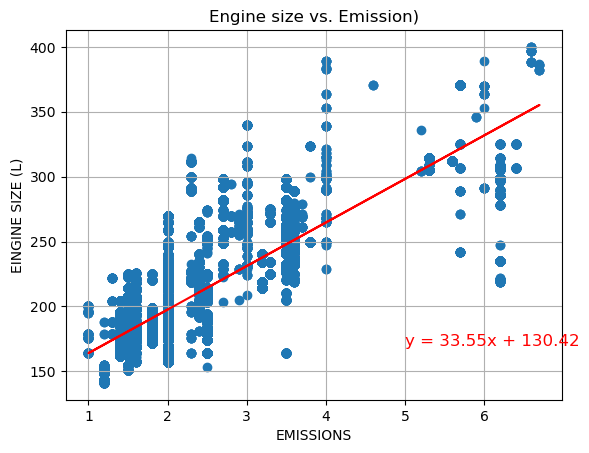

In [174]:
#engine_size vs emissions
x = final_tweak_df['ENGINE SIZE']
y = final_tweak_df['EMISSIONS']
y_label = "EINGINE SIZE (L)"
x_cord = 5
y_cord = 170
linear_regression_plot(x,y,x_cord,y_cord,y_label)
# Set a title
plt.title(f"Engine size vs. Emission)")
plt.show()


There is direct relationship between engine size and emissions. As engine size increases the emissions also increase.

In [175]:
body_count = final_tweak_df.groupby('BODY TYPE')['BRAND'].count()
body_count.index

Index(['Cargo Van', 'Convertible', 'Coupe', 'Crossover', 'Hatchback',
       'Minivan', 'Pickup', 'SUV', 'Sedan', 'Targa', 'Wagon'],
      dtype='object', name='BODY TYPE')

In [176]:
city_list = final_tweak_df[["CITY","COUNTRY","STATE","EMISSIONS"]]
city_list["STATE"] = city_list["STATE"].replace({"ON" : "Ontario", "AB": "Alberta", "NS": "Nova Scotia","SK": "Saskatchewan","BC" : "British Columbia","MB":"Manitoba","NB":"New Brunswick","NL" :"Newfoundland and Labrador",
                                                        "NT" : "Northwest Territories", "NU" : "Nunavut", "PE" : "Prince Edward Island", "QC" : "Quebec" ,"YT":"Yukon"})
unique_cities = city_list['CITY'].unique()

result_df = pd.DataFrame(columns=["CITY", "STATE"])
result_list = []
for city in unique_cities:
    state = city_list.loc[city_list["CITY"] == city, "STATE"].iloc[0]
    result_list.append({"CITY": city, "STATE": state})

result_df = pd.DataFrame(result_list)
result_df["latitude"] = ""
result_df["longitude"] = ""
result_df['CITY'] = result_df['CITY'].replace(to_replace=r'[^a-zA-Z0-9]', value='', regex=True) #stackoverflow source: 
result_df['CITY'] = result_df['CITY'].drop_duplicates()
result_df['CITY'].count()


/var/folders/qh/th17k7b126bdp6fpt44nzdb80000gn/T/ipykernel_40385/770266285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_list["STATE"] = city_list["STATE"].replace({"ON" : "Ontario", "AB": "Alberta", "NS": "Nova Scotia","SK": "Saskatchewan","BC" : "British Columbia","MB":"Manitoba","NB":"New Brunswick","NL" :"Newfoundland and Labrador",


605

In [177]:
emission_grp = final_tweak_df.groupby('COUNTRY')
emission_grp_mean = round(emission_grp['EMISSIONS'].mean())
emission_grp_count = emission_grp['MODEL'].count()
emission_grp_df = pd.DataFrame({ "EMISSIONS" : emission_grp_mean,
                                "No of cars": emission_grp_count})
emission_grp_df["LATITUDE"] = ""
emission_grp_df["LONGITUDE"] = ""
emission_grp_df["COUNTRY"] = emission_grp_df.index.values
emission_grp_df.reset_index(inplace= True,drop = True)
emission_grp_df["COUNTRY"] = emission_grp_df['COUNTRY'].replace({"UK": "United Kingdom"})
emission_grp_df

,EMISSIONS,No of cars,LATITUDE,LONGITUDE,COUNTRY
0,196.0,11835,,,Germany
1,283.0,109,,,Italy
2,194.0,34979,,,Japan
3,200.0,27284,,,South Korea
4,285.0,378,,,United Kingdom
5,217.0,42629,,,USA


In [178]:
base_url = "https://api.geoapify.com/v1/geocode/search"
params = {
    "apiKey":geoapify_key,
    "format":"json"
}

for index, row in emission_grp_df.iterrows():
    country = row["COUNTRY"]
    params["text"] = f"{country}"
    response = requests.get(base_url, params=params)
    response = response.json()
    emission_grp_df.loc[index,"LATITUDE"] = response["results"][0]["lat"]
    emission_grp_df.loc[index,"LONGITUDE"] = response["results"][0]["lon"]  
emission_grp_df

,EMISSIONS,No of cars,LATITUDE,LONGITUDE,COUNTRY
0,196.0,11835,51.163818,10.447831,Germany
1,283.0,109,42.638426,12.674297,Italy
2,194.0,34979,36.574844,139.239418,Japan
3,200.0,27284,36.638392,127.696119,South Korea
4,285.0,378,54.702354,-3.276575,United Kingdom
5,217.0,42629,39.78373,-100.445882,USA


In [179]:
# configuring the map plot_2 to show the respective countries of the car manufacturers and their emissions.
map_plot = emission_grp_df.hvplot.points(
    "LONGITUDE",
    "LATITUDE",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 500,
    color =  "COUNTRY",   
)
# Display the map plot
map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [LONGITUDE,LATITUDE]   (COUNTRY)

Text(6, 393, '393')

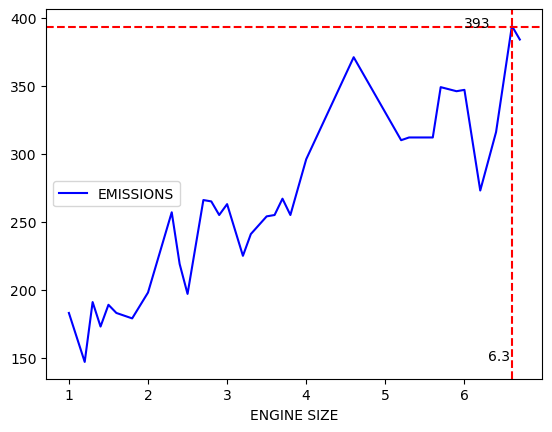

In [180]:
# on an average the most no vs engine 
engine_grp = final_tweak_df.groupby('ENGINE SIZE')
eng_emi = round(engine_grp['EMISSIONS'].mean())
eng_emi_df = pd.DataFrame(eng_emi)
eng_emi_df.plot(kind = 'line', color = 'blue')
plt.axvline(6.6,color = 'red',linestyle = '--')
plt.axhline(393,color = 'red',linestyle = '--')
plt.text(6.3, 148, "6.3")
plt.text(6,393,"393")

In [181]:
most_pol = [final_tweak_df['EMISSIONS'].max()]
print(most_pol)
most_poll = final_tweak_df.loc[final_tweak_df['EMISSIONS'] == 400,:]
most_poll

[400.0]


,BRAND,MODEL,YEAR,FUEL TYPE,MILES,PRICE,ENGINE SIZE,BODY TYPE,CITY,STATE,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,COUNTRY
434211,Rolls-Royce,Dawn,2020.0,Premium Unleaded,550.0,548841.0,6.6,Convertible,Laval,QC,20.4,13.1,17.1,17.0,400.0,UK
434212,Rolls-Royce,Dawn,2020.0,Premium Unleaded,550.0,548841.0,6.6,Convertible,Mont-royal,QC,20.4,13.1,17.1,17.0,400.0,UK
434213,Rolls-Royce,Dawn,2020.0,Premium Unleaded,1901.0,489900.0,6.6,Convertible,Mont-royal,QC,20.4,13.1,17.1,17.0,400.0,UK
434214,Rolls-Royce,Dawn,2020.0,Premium Unleaded,1901.0,489900.0,6.6,Convertible,Laval,QC,20.4,13.1,17.1,17.0,400.0,UK
